## Project 2 Baseline
Quora Project



# Load Data and Import Libraries

First, we load all data and necessary libraries. We split the `train` data into `miniTrain` and `miniTest` dataframes.



In [1]:
#Import Libraries
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import csv
import random

In [2]:
# # Code to read csv file from Google Drive into Colaboratory:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [3]:
# #Load test DF
# testLink = 'https://drive.google.com/file/d/1chKVOcXwNzGRe_hRxpGlq18NVaSRM8X9/view?usp=sharing'
# idTest = testLink.split('/')[-2]
# downloaded = drive.CreateFile({'id':idTest}) 
# downloaded.GetContentFile('test.csv')  
# test = pd.read_csv('test.csv')
# test

In [4]:
# #Load train DF
# trainLink = 'https://drive.google.com/file/d/1fP-AWiUGLjLkL0c_u67HOUFmHOMO7qm2/view?usp=sharing'
# idTrain = trainLink.split('/')[-2]
# downloaded = drive.CreateFile({'id':idTrain}) 
# downloaded.GetContentFile('train.csv')  

In [5]:
# train = pd.read_csv('train.csv')
# train

In [6]:
# #Split Training Data into MiniTrain and MiniTest (Test data has no labels so impossible to measure error from it)
# # random.seed(10)
# # miniTrain, miniDev, miniTest = train_test_split(train, test_size=0.2)

# miniTrain, miniDev, miniTest = \
#               np.split(train.sample(frac=1, random_state=42), 
#                        [int(.8*len(train)), int(.9*len(train))])

# miniTrain.to_csv('miniTrain.csv', index=False)

# miniTest.to_csv('miniTest.csv', index=False)

# miniDev.to_csv('miniDev.csv', index = False)

# print("miniTrain: ",len(miniTrain), "observations, ", round(len(miniTrain)/len(train)*100,0), "%;\n" ,
#       "miniDev: ",len(miniDev), "observations, ", round(len(miniDev)/len(train)*100,0), "%;\n" ,
#       "miniTest: ",len(miniTest), "observations, ", round(len(miniTest)/len(train)*100,0), "%;" )

In [7]:
#Even with a seed the randomization is messing up predictions since miniTest will not find the same questions further down, 
#so rather load a static version from a csv instead.

columns = [
    "id",
    "label",
    "alpha",
    "text"
]

miniTrain = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/train.tsv', names=columns, sep="\t")

miniTest = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/test.tsv', names=columns, sep="\t")

miniDev = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/dev.tsv', names=columns, sep="\t")

## `txtprp` Module 

In [8]:
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import nltk as nltk
import re
import gensim 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE, RandomOverSampler

class TextObject(pd.DataFrame):
    """
    A collection of strings for processing. Is a DataFrame with specific 
    columns. 
    """

    def __init__(self):
        super().__init__(columns=[
            "original_text",
            "text",
            "label"
        ]
        )
        self._attrs["applied_transformations"] = []
        nltk.download("stopwords")
        nltk.download("punkt")

    def add_text(self, text_collection, labels=None):
        """
        Adds a collection of text to to the TextObject. Accepts an iterable or 
        array-like of all text strings. Optionally, accepts labels of the same 
        length. Modifies self to be a pandas DataFrame with column "text" and 
        potentially "labels".
        """
        self["original_text"] = text_collection
        self["text"] = self.original_text
        self._attrs["applied_transformations"] = []
        if type(labels) == type(None):
            return
        if len(labels) == len(self):
            self["label"] = labels

    # Text Processing Methods:

    def text_processing(self, function):
        """
        Applies a generic text processing function to the self.text field.
        """
        self.text = self.text.apply(function)
        self._attrs["applied_transformations"].append(function.__name__)

    def lower(self):
        self.text = self.text.str.lower()
        self._attrs["applied_transformations"].append("lower")
    
    def strip(self):
        self.text = self.text.str.strip()
        self._attrs["applied_transformations"].append("strip")

    def remove_single_digits(self):
        self.text = self.text.apply(lambda text: re.sub("([\d]+)", "", text))
        self._attrs["applied_transformations"].append("remove_single_digits")
    
    def remove_nonletter_chars(self):
        self.text = self.text.apply(lambda text: re.sub("[^A-Za-z0-9 \\n]", " ", text))
        self._attrs["applied_transformations"].append("remove_nonletter_chars")

    def stop_word_tokenize(self):
        def tokenize(text):
            self.stoplist = nltk.corpus.stopwords.words('english')
            finalTokens = []
            tokens = nltk.word_tokenize(text)
            for w in tokens:
                if (w not in self.stoplist):
                    finalTokens.append(w)
            text = " ".join(finalTokens)
            return text
        self.text = self.text.apply(tokenize)
        self._attrs["applied_transformations"].append("stop_word_tokenize")
    
    def stem_sentence(self):
        def stem(text):
            porter=PorterStemmer()
            token_words=nltk.tokenize.word_tokenize(text)
            token_words
            stem_sentence=[]
            for word in token_words:
                stem_sentence.append(porter.stem(word))
                stem_sentence.append(" ")
            return "".join(stem_sentence)
        self.text = self.text.apply(stem)
        self._attrs["applied_transformations"].append("stem_sentence")

    def lemmatize_sentence(self):
        def lem(text):
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            #token_words
            token_words=nltk.tokenize.word_tokenize(text)
            lemm_sentence=[]
            for word in token_words:
                lemm_sentence.append(wordnet_lemmatizer.lemmatize(word))
                lemm_sentence.append(" ")
            return "".join(lemm_sentence)
        self.text = self.text.apply(lem)
        self._attrs["applied_transformations"].append("lemmatize_sentence")

    def process_all(self, lower=True, strip=True, remove_single_digits =True, 
        remove_nonletter_chars=True, stop_word_tokenize=True, stem_sentence=True,
        lemmatize_sentence=True):
        if lower:
            self.lower()
        if strip:
            self.strip()
        if remove_single_digits:
            self.remove_single_digits()
        if remove_nonletter_chars:
            self.remove_nonletter_chars()
        if stop_word_tokenize:
            self.stop_word_tokenize()
        if stem_sentence:
            self.stem_sentence()
        if lemmatize_sentence:
            self.lemmatize_sentence()


# Naive Bayes Model

In [9]:
train = TextObject()
train.add_text(miniTrain.text, labels=miniTrain.label)
print(train.__dict__)
train

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'_is_copy': None, '_mgr': BlockManager
Items: Index(['original_text', 'text', 'label'], dtype='object')
Axis 1: RangeIndex(start=0, stop=1044897, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 1044897, dtype: object
NumericBlock: slice(2, 3, 1), 1 x 1044897, dtype: int64, '_item_cache': {}, '_attrs': {'applied_transformations': []}, '_flags': <Flags(allows_duplicate_labels=True)>}


,original_text,text,label
0,What is the most effective classroom managemen...,What is the most effective classroom managemen...,0
1,Can I study abroad after 10th class from Bangl...,Can I study abroad after 10th class from Bangl...,0
2,How can I make friends as a college junior?,How can I make friends as a college junior?,0
3,How do I download free APK Minecraft: Pocket E...,How do I download free APK Minecraft: Pocket E...,0
4,"Like Kuvera, is ""Groww"" also a free online inv...","Like Kuvera, is ""Groww"" also a free online inv...",0
...,...,...,...
1044892,How is a video similar to ordinary graphics?,How is a video similar to ordinary graphics?,0
1044893,How does training with a speed bag make you a ...,How does training with a speed bag make you a ...,0
1044894,What marketing strategies are implemented to i...,What marketing strategies are implemented to i...,0
1044895,What are the characteristics of wireless adapt...,What are the characteristics of wireless adapt...,0


In [10]:
test = TextObject()
test.add_text(miniTest.text, labels=miniTest.label)
print(test.__dict__)
test

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['original_text', 'text', 'label'], dtype='object')
Axis 1: RangeIndex(start=0, stop=130612, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 130612, dtype: object
NumericBlock: slice(2, 3, 1), 1 x 130612, dtype: int64, '_item_cache': {}, '_attrs': {'applied_transformations': []}, '_flags': <Flags(allows_duplicate_labels=True)>}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,original_text,text,label
0,Does my BDS degree from India count if I want ...,Does my BDS degree from India count if I want ...,0
1,Is there such a thing as an average face?,Is there such a thing as an average face?,0
2,Is Munich Volkshochschule a good choice to lea...,Is Munich Volkshochschule a good choice to lea...,0
3,What is The relationship between Texas and its...,What is The relationship between Texas and its...,0
4,Will the current mining equipment work with se...,Will the current mining equipment work with se...,0
...,...,...,...
130607,What's the best way to teach your daughter to ...,What's the best way to teach your daughter to ...,0
130608,What are similarities and differences between ...,What are similarities and differences between ...,0
130609,What is the best shoe cleaning product for tri...,What is the best shoe cleaning product for tri...,0
130610,Can I get a private medical college with 320 m...,Can I get a private medical college with 320 m...,0


In [11]:
dev = TextObject()
dev.add_text(miniDev.text, labels=miniDev.label)
print(dev.__dict__)
dev

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['original_text', 'text', 'label'], dtype='object')
Axis 1: RangeIndex(start=0, stop=130613, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 130613, dtype: object
NumericBlock: slice(2, 3, 1), 1 x 130613, dtype: int64, '_item_cache': {}, '_attrs': {'applied_transformations': []}, '_flags': <Flags(allows_duplicate_labels=True)>}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,original_text,text,label
0,Where can I find best romantic shayaris?,Where can I find best romantic shayaris?,1
1,When we check the UPSC rank list; many of the ...,When we check the UPSC rank list; many of the ...,0
2,Is there is any web site to create search engi...,Is there is any web site to create search engi...,0
3,How can you earn $50 just clicking ads?,How can you earn $50 just clicking ads?,0
4,Which 3 branches of engineering have the most ...,Which 3 branches of engineering have the most ...,0
...,...,...,...
130608,How can the ViewSonic PA503S 3600 lumens SVGA ...,How can the ViewSonic PA503S 3600 lumens SVGA ...,0
130609,What are the biggest myths about Adolf Hitler?,What are the biggest myths about Adolf Hitler?,0
130610,What song played in the movie of the gifted wh...,What song played in the movie of the gifted wh...,0
130611,"What do Socrates, Thomas Kuhn and Karl Popper ...","What do Socrates, Thomas Kuhn and Karl Popper ...",0


In [12]:
train.lower()
train.strip()
train.remove_single_digits()
train.remove_nonletter_chars()
train.stop_word_tokenize()
train

<ipython-input-8-7fe0180fad7b>:69: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.stoplist = nltk.corpus.stopwords.words('english')


,original_text,text,label
0,What is the most effective classroom managemen...,effective classroom management skill technique...,0
1,Can I study abroad after 10th class from Bangl...,study abroad th class bangladesh,0
2,How can I make friends as a college junior?,make friends college junior,0
3,How do I download free APK Minecraft: Pocket E...,download free apk minecraft pocket edition ios...,0
4,"Like Kuvera, is ""Groww"" also a free online inv...",like kuvera groww also free online investment ...,0
...,...,...,...
1044892,How is a video similar to ordinary graphics?,video similar ordinary graphics,0
1044893,How does training with a speed bag make you a ...,training speed bag make better fighter,0
1044894,What marketing strategies are implemented to i...,marketing strategies implemented increase sale...,0
1044895,What are the characteristics of wireless adapt...,characteristics wireless adapters,0


# NB Model

In [13]:
x = train['text']
y = train['label']
print('train data shape: ', x.shape)
print('train label shape:', y.shape)
x_test = test['text']
y_test = test['label']
print('test data shape: ', x_test.shape)
print('test label shape:', y_test.shape)

train data shape:  (1044897,)
train label shape: (1044897,)
test data shape:  (130612,)
test label shape: (130612,)


In [14]:
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x)
x_test = vec.transform(x_test)

In [15]:
from sklearn.naive_bayes import ComplementNB
model_prep = ComplementNB(alpha=0.01)
model_prep.fit(x, y)

ComplementNB(alpha=0.01)

In [16]:
y_pred = model_prep.predict(x_test)
y_probs = [i[1] for i in model_prep.predict_proba(x_test)]

In [17]:
print(y_probs[:10], y_pred[:10])

[9.49716997689671e-09, 0.4246347811973764, 0.0013553633760733455, 0.6619439202006367, 0.001464110182772294, 0.18940724590033436, 0.9821347700637032, 5.790107948684731e-13, 0.00019209905144785844, 0.9994264692640603] [0 0 0 1 0 0 1 0 0 1]


Model After Processed data 

Accuracy: 0.821563102930818
F1 score: 0.378307725138711
Recall: 0.24178259683578832
Precision: 0.8689950980392157

 Clasification report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90    101284
           1       0.87      0.24      0.38     29328

    accuracy                           0.82    130612
   macro avg       0.84      0.62      0.64    130612
weighted avg       0.83      0.82      0.78    130612


 Confusion matrix:



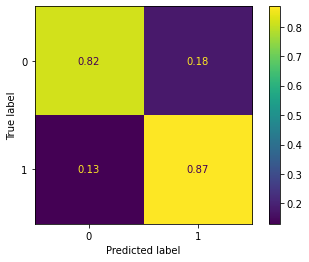

In [18]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, plot_confusion_matrix
from matplotlib import pyplot as plt
print("Model After Processed data \n")
print('Accuracy:', accuracy_score(y_pred, y_test))
print('F1 score:', f1_score(y_pred, y_test))
print('Recall:', recall_score(y_pred, y_test))
print('Precision:', precision_score(y_pred, y_test))
print('\n Clasification report:\n', classification_report(y_pred, y_test))
print('\n Confusion matrix:\n')
disp = plot_confusion_matrix(model_prep, x_test, y_test, normalize='true',values_format=".2f")

In [19]:
calcDF = pd.DataFrame(data=[y_probs, y_test], index=['pred','label']).T
calcDF

,pred,label
0,9.497170e-09,0.0
1,4.246348e-01,0.0
2,1.355363e-03,0.0
3,6.619439e-01,0.0
4,1.464110e-03,0.0
...,...,...
130607,4.178595e-02,0.0
130608,9.151326e-03,0.0
130609,6.060790e-03,0.0
130610,5.716538e-07,0.0


In [20]:
def frange(start, stop, step):
  i = start
  while i < stop:
    yield i
    i += step

columnNames = ['threshold', 'f1Score', 'accuracy', 'recall', 'precision']
thresholdDF = pd.DataFrame(columns=columnNames)

for i in frange(0.05,1,0.01):
    calcDF['pred2'] = np.where(calcDF['pred'] > i, 1, 0)
    f1Score = f1_score(calcDF.label, calcDF.pred2)
    accuracy = accuracy_score(calcDF.label, calcDF.pred2)
    recall = recall_score(calcDF.label, calcDF.pred2)
    precision = precision_score(calcDF.label, calcDF.pred2)
    thresholdDF = thresholdDF.append({'threshold': i, 'f1Score': f1Score, 
                                      'accuracy':accuracy, 'recall':recall, 
                                      'precision':precision}, 
                                      ignore_index=True)

thresholdDF

,threshold,f1Score,accuracy,recall,precision
0,0.05,0.235594,0.618634,0.940686,0.134660
1,0.06,0.241060,0.631634,0.936397,0.138336
2,0.07,0.246183,0.642812,0.933578,0.141786
3,0.08,0.251078,0.652873,0.931373,0.145096
4,0.09,0.255348,0.661517,0.928922,0.148018
...,...,...,...,...,...
90,0.95,0.541075,0.927204,0.686887,0.446329
91,0.96,0.544953,0.930596,0.665196,0.461525
92,0.97,0.549459,0.934371,0.640564,0.481042
93,0.98,0.549818,0.938390,0.602206,0.505816


In [21]:
 #Find the optimum threshold and save it to variable to use further down creating predictions
 #Depending on the original random sample, optimum threshold will oscillate between 0.2 and 0.25
 
optimumThreshold = thresholdDF.loc[thresholdDF['f1Score'].idxmax()][0]

optimumThreshold

0.9800000000000006

In [22]:
#Compute baseline F1 Score (and other metrics)

y_pred2 = np.where(y_probs > optimumThreshold, 1, 0)

print('Accuracy:', accuracy_score(y_test, y_pred2))
print('F1 score:', f1_score(y_test, y_pred2))
print('Recall:', recall_score(y_test, y_pred2))
print('Precision:', precision_score(y_test, y_pred2))
print('\n Clasification report:\n', classification_report(y_test, y_pred2))

Accuracy: 0.9383900407313264
F1 score: 0.5498181818181818
Recall: 0.6022058823529411
Precision: 0.5058157488419969

 Clasification report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97    122452
           1       0.51      0.60      0.55      8160

    accuracy                           0.94    130612
   macro avg       0.74      0.78      0.76    130612
weighted avg       0.94      0.94      0.94    130612



In [23]:
# from joblib import dump

# dump(model_prep, "nb_model.joblib")
# dump(vec, "nb_cv.joblib")
# dump(optimumThreshold, "nb_ot.joblib")